In [1]:
from collections import namedtuple
import jax
import jax.numpy as jnp
import numpy as np
import os, argparse
import time
import torch
import bayes3d as b
from bayes3d.rendering.nvdiffrast_jax.jax_renderer import Renderer as JaxRenderer

intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=75.0, fy=75.0,
    cx=50.0, cy=50.0,
    near=0.001, far=16.0
)
from bayes3d.rendering.nvdiffrast_jax.jax_renderer import Renderer as JaxRenderer
jax_renderer = JaxRenderer(intrinsics)


model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
idx = 17
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
m = b.utils.load_mesh(mesh_path)
m = b.utils.scale_mesh(m, 1.0/100.0)

vertices = jnp.array(m.vertices.astype(np.float32))
faces = jnp.array(m.faces.astype(np.int32))

pose = b.transform_from_pos(jnp.array([0.0, 0.0, 2.0]))
poses = jnp.array([pose, pose, pose, pose, pose])

GenJAX not installed. Importing bayes3d without genjax dependencies.


In [5]:
imgs = jax_renderer.render_many(vertices, faces, jnp.tile(pose[None,...], (1000,1,1)), intrinsics)
print(imgs.shape)

2023-11-29 05:12:37.898566: W external/xla/xla/service/gpu/runtime/support.cc:58] Intercepted XLA runtime error:
UNKNOWN: jax_rasterize_fwd_gl XLA extension have thrown an exception: Cuda error: 2[cudaGraphicsGLRegisterBuffer(&s.cudaPosBuffer, s.glPosBuffer, cudaGraphicsRegisterFlagsWriteDiscard);]
Exception raised from rasterizeResizeBuffers at /home/nishadgothoskar/bayes3d/bayes3d/rendering/nvdiffrast_jax/nvdiffrast/common/rasterize_gl.cpp:371 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x57 (0x7fd6207e7617 in /home/nishadgothoskar/.local/lib/python3.9/site-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7fd6207a298d in /home/nishadgothoskar/.local/lib/python3.9/site-packages/torch/lib/libc10.so)
frame #2: rasterizeResizeBuffers(int, RasterizeGLState&, bool&, int, int, int, int, int) + 0x332 (0x7fd5d8950a49 in /home/nishadgothoskar/.cache/torch_exten

XlaRuntimeError: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.custom_call' failed: jax_rasterize_fwd_gl XLA extension have thrown an exception: Cuda error: 2[cudaGraphicsGLRegisterBuffer(&s.cudaPosBuffer, s.glPosBuffer, cudaGraphicsRegisterFlagsWriteDiscard);]
Exception raised from rasterizeResizeBuffers at /home/nishadgothoskar/bayes3d/bayes3d/rendering/nvdiffrast_jax/nvdiffrast/common/rasterize_gl.cpp:371 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x57 (0x7fd6207e7617 in /home/nishadgothoskar/.local/lib/python3.9/site-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7fd6207a298d in /home/nishadgothoskar/.local/lib/python3.9/site-packages/torch/lib/libc10.so)
frame #2: rasterizeResizeBuffers(int, RasterizeGLState&, bool&, int, int, int, int, int) + 0x332 (0x7fd5d8950a49 in /home/nishadgothoskar/.cache/torch_extensions/py39_cu118/nvdiffrast_plugin_differentiable_gl/nvdiffrast_plugin_differentiable_gl.so)
frame #3: _rasterize_fwd_gl(CUstream_st*, RasterizeGLStateWrapper&, float const*, int const*, std::vector<int, std::allocator<int> >, std::vector<int, std::allocator<int> >, float*, float*) + 0x1a4 (0x7fd5d896c23a in /home/nishadgothoskar/.cache/torch_extensions/py39_cu118/nvdiffrast_plugin_differentiable_gl/nvdiffrast_plugin_differentiable_gl.so)
frame #4: jax_rasterize_fwd_gl(CUstream_st*, void**, char const*, unsigned long) + 0x286 (0x7fd5d896c5b9 in /home/nishadgothoskar/.cache/torch_extensions/py39_cu118/nvdiffrast_plugin_differentiable_gl/nvdiffrast_plugin_differentiable_gl.so)
frame #5: <unknown function> + 0x2fe1121 (0x7fd6d5f01121 in /opt/conda/envs/bayes3d/lib/python3.9/site-packages/jaxlib/xla_extension.so)
frame #6: <unknown function> + 0x2fe1e32 (0x7fd6d5f01e32 in /opt/conda/envs/bayes3d/lib/python3.9/site-packages/jaxlib/xla_extension.so)
frame #7: [0x7fd5d4a072f6]
; current tracing scope: custom-call.4; current profiling annotation: XlaModule:#hlo_module=jit_rasterize_multiple_fwd_140557556960992,program_id=65#.

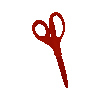

In [40]:
depth, _ = jax_renderer.render(vertices, faces, pose, intrinsics)
b.get_depth_image(depth[0])

(5, 100, 100)


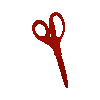

In [46]:
projection_matrix = b.camera._open_gl_projection_matrix(
    intrinsics.height, intrinsics.width, 
    intrinsics.fx, intrinsics.fy, 
    intrinsics.cx, intrinsics.cy, 
    intrinsics.near, intrinsics.far
)
composed_projection = projection_matrix @ poses
vertices_homogenous = jnp.concatenate([vertices, jnp.ones((*vertices.shape[:-1],1))], axis=-1)
clip_spaces_projected_vertices = jnp.einsum("nij,mj->nmi", composed_projection, vertices_homogenous)
rast_out, rast_out_db = jax_renderer.rasterize(clip_spaces_projected_vertices, faces, jnp.array([intrinsics.height, intrinsics.width]))
interpolated_collided_vertices_clip, _ = jax_renderer.interpolate(jnp.tile(vertices_homogenous[None,...],(poses.shape[0],1,1)), rast_out, faces, rast_out_db, jnp.array([0,1,2,3]))
interpolated_collided_vertices = jnp.einsum("a...ij,a...j->a...i", poses, interpolated_collided_vertices_clip)
mask = rast_out[...,-1] > 0
depth = interpolated_collided_vertices[...,2] * mask
print(depth.shape)
b.get_depth_image(depth[0])

In [36]:
interpolated_collided_vertices.shape

(3, 100, 100, 4)

Array([[[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        ...,

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
 